In [4]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [5]:
# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Register the DataFrame as a temporary SQL view
df.createOrReplaceTempView("job_postings")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# comment the lines below when rendering the submission
df.printSchema()
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

In [6]:

# Create output directory if it doesn't exist
if not os.path.exists('output'):
    os.makedirs('output')


from pyspark.sql.functions import col, monotonically_increasing_id

industries_df = df.select(
    col("naics_2022_6"),
    col("naics_2022_6_name"),
    col("soc_5").alias("soc_code"),
    col("soc_5_name").alias("soc_name"),
    col("lot_specialized_occupation_name").alias("specialized_occupation"),
    col("lot_occupation_group").alias("occupation_group")
).distinct().withColumn("industry_id", monotonically_increasing_id())


industries_df = industries_df.select(
    "industry_id",
    "naics_2022_6",
    "naics_2022_6_name",
    "soc_code",
    "soc_name",
    "specialized_occupation",
    "occupation_group"
)

industries_df.show(5, truncate=False)

locations_df = df.select(
    col("location"),
    col("city_name"),
    col("state_name"),
    col("county_name"),
    col("msa"),
    col("msa_name"),
).distinct().withColumn("location_id", monotonically_increasing_id())

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
companies_df = df.select(
    col("company"),
    col("company_name"),
    col("company_raw"),
    col("company_is_staffing"),
).distinct().where(F.col("company").isNotNull()).where(F.col("company_name") != 'Unclassified').withColumn("company_id", monotonically_increasing_id())
company_df = companies_df.dropna()


from pyspark.sql.functions import lower
job_postings_df = df.select(
    col("ID").alias("job_postings_id"),
    "title_clean","employment_type_name","remote_type_name","remote_type","body",
    "min_years_experience","max_years_experience","salary","salary_from","salary_to",
    "posted","expired","duration",
    "company","location","naics_2022_6"
).dropDuplicates(["job_postings_id"]) \
 .join(companies_df.select("company","company_id"), on="company", how="left") \
 .join(locations_df.select("location","location_id"), on="location", how="left") \
 .join(industries_df.select("naics_2022_6","industry_id"), on="naics_2022_6", how="left")



+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|industry_id|naics_2022_6|naics_2022_6_name                            |soc_code|soc_name       |specialized_occupation|occupation_group|
+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|0          |541613      |Marketing Consulting Services                |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|1          |311513      |Cheese Manufacturing                         |15-2051 |Data Scientists|Data Analyst          |2311            |
|2          |522110      |Commercial Banking                           |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|3          |485310      |Taxi and Ridesharing Services                |15-2051 |Data Scientists|Data Analyst          |2311            |
|4          |713990      |All Othe

In [7]:

companies_df.createOrReplaceTempView("companies")
industries_df.createOrReplaceTempView("industries")
locations_df.createOrReplaceTempView("locations")
job_postings_df.createOrReplaceTempView("job_postings")


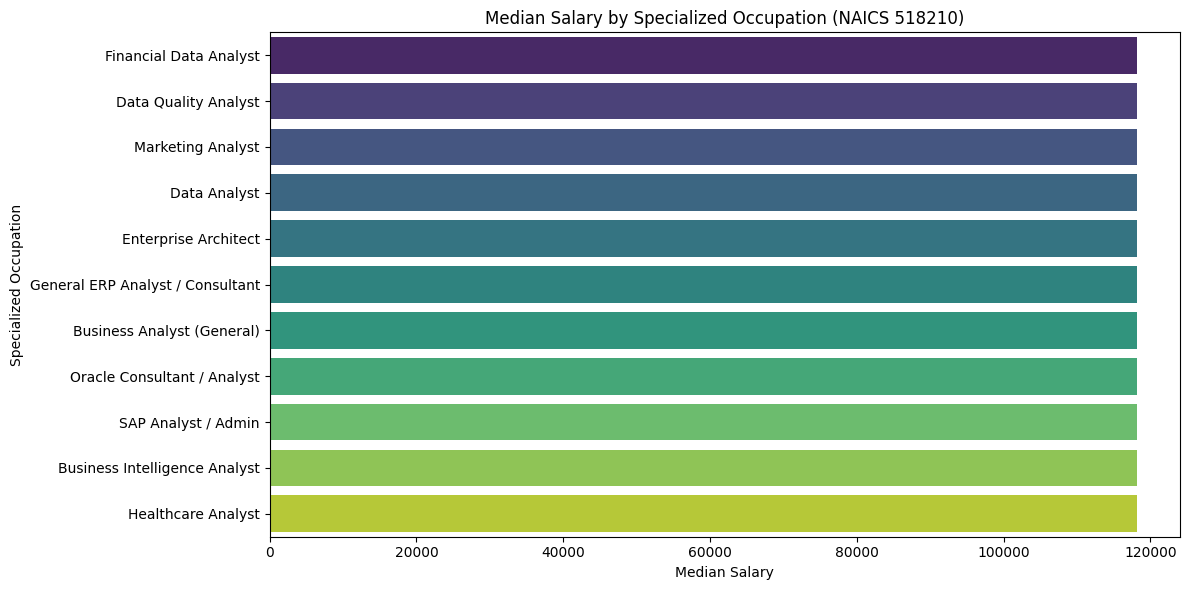

In [8]:
## QUERY 1 Industry-Specific Salary Trends Grouped by Job Titl

tech_salary_trends = spark.sql("""
SELECT
    i.naics_2022_6_name AS industry_name,
    i.specialized_occupation,
    PERCENTILE_APPROX(j.salary, 0.5) AS median_salary
FROM job_postings j
JOIN industries i
    ON j.naics_2022_6 = i.naics_2022_6
WHERE i.naics_2022_6 = 518210
  AND j.salary IS NOT NULL
  AND j.salary > 0
GROUP BY i.naics_2022_6_name, i.specialized_occupation
ORDER BY median_salary DESC
""")


tech_salary_pd = tech_salary_trends.toPandas()

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=tech_salary_pd, x="median_salary", y="specialized_occupation", palette="viridis", hue="specialized_occupation", legend=False)
ax.set_xlabel("Median Salary")
ax.set_ylabel("Specialized Occupation")
ax.set_title("Median Salary by Specialized Occupation (NAICS 518210)")
plt.tight_layout()
plt.savefig('output/tech_salary_trends.png')
plt.show()


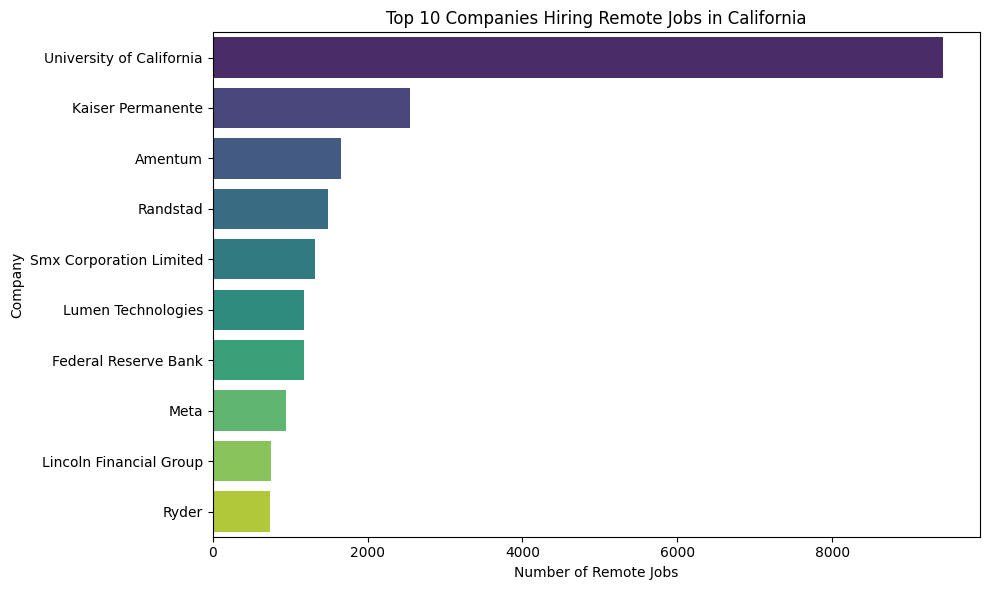

In [9]:

# QUERY 2 : Top 5 Companies with the Most Remote Jobs in California

remote_jobs_ca = spark.sql("""
    SELECT
        COALESCE(c.company_name) AS company_name,
        COUNT(*) AS remote_jobs
    FROM job_postings j
    JOIN companies c  ON j.company_id  = c.company_id
    JOIN locations l  ON j.location_id = l.location_id
    WHERE (j.remote_type = 1 OR LOWER(j.remote_type_name) LIKE 'remote%')
      AND l.state_name = 'California'
    GROUP BY COALESCE(c.company_name)
    ORDER BY remote_jobs DESC
    LIMIT 10
""")

remote_jobs_ca_pd = remote_jobs_ca.toPandas()

remote_jobs_ca_pd.head()

plt.figure(figsize=(10, 6))
sns.barplot(x="remote_jobs", y="company_name", data=remote_jobs_ca_pd, palette="viridis", hue="company_name", legend=False)
plt.title("Top 10 Companies Hiring Remote Jobs in California")
plt.xlabel("Number of Remote Jobs")
plt.ylabel("Company")
plt.tight_layout()
plt.savefig('output/remote_jobs_ca.png')
plt.show()



+----+-----+---------+
|year|month|job_count|
+----+-----+---------+
|2024|    5|    75160|
|2024|    6|    54746|
|2024|    7|    37118|
|2024|    8|    46916|
|2024|    9|    50260|
+----+-----+---------+



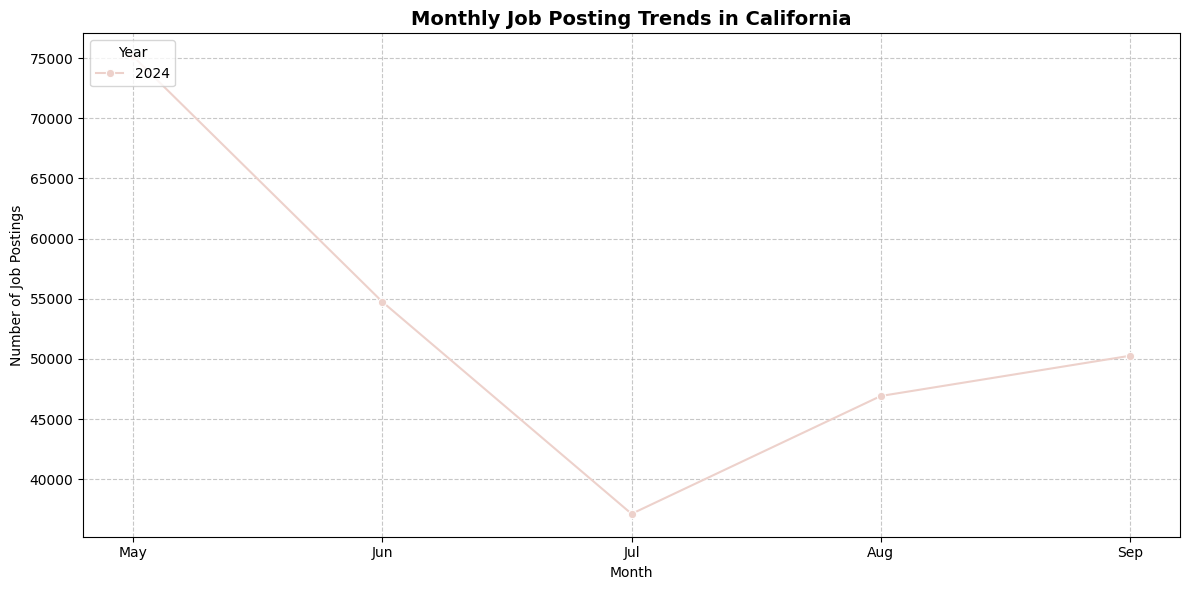

In [36]:
# Query 3: Monthly Job Posting Trends in California

from pyspark.sql.functions import to_date, year, month, coalesce, col
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Convert posted column to a valid date format (multiple patterns handled)
job_postings_with_date = job_postings_df.withColumn(
    "posted_date",
    coalesce(
        to_date(col("posted"), "yyyy-MM-dd"),
        to_date(col("posted"), "MM/dd/yyyy"),
        to_date(col("posted"), "MM-dd-yyyy"),
        to_date(col("posted"), "dd-MM-yyyy"),
        to_date(col("posted"), "yyyy/MM/dd")
    )
).withColumn(
    "year", year(col("posted_date"))
).withColumn(
    "month", month(col("posted_date"))
)

# Register temp views
job_postings_with_date.createOrReplaceTempView("job_postings_with_date")
locations_df.createOrReplaceTempView("locations")

# SQL query for monthly trends in California
monthly_trends_ca = spark.sql("""
SELECT
    YEAR(
        COALESCE(
            TO_DATE(j.posted, 'M/d/yyyy'),
            TO_DATE(j.posted, 'MM/dd/yyyy')
        )
    ) AS year,
    MONTH(
        COALESCE(
            TO_DATE(j.posted, 'M/d/yyyy'),
            TO_DATE(j.posted, 'MM/dd/yyyy')
        )
    ) AS month,
    COUNT(*) AS job_count
FROM job_postings j
JOIN locations l
    ON j.location_id = l.location_id
WHERE l.state_name = 'California'
  AND COALESCE(
        TO_DATE(j.posted, 'M/d/yyyy'),
        TO_DATE(j.posted, 'MM/dd/yyyy')
      ) IS NOT NULL
GROUP BY
    YEAR(
        COALESCE(
            TO_DATE(j.posted, 'M/d/yyyy'),
            TO_DATE(j.posted, 'MM/dd/yyyy')
        )
    ),
    MONTH(
        COALESCE(
            TO_DATE(j.posted, 'M/d/yyyy'),
            TO_DATE(j.posted, 'MM/dd/yyyy')
        )
    )
ORDER BY year, month;

""")

monthly_trends_ca.show(10)

# Convert to Pandas
monthly_trends_ca_pd = monthly_trends_ca.toPandas()

# Clean up and convert month numbers
monthly_trends_ca_pd = monthly_trends_ca_pd.dropna(subset=["month"])
monthly_trends_ca_pd["month"] = monthly_trends_ca_pd["month"].astype(int)
monthly_trends_ca_pd["month_name"] = monthly_trends_ca_pd["month"].apply(lambda x: calendar.month_abbr[x])

# Plot trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends_ca_pd, x="month_name", y="job_count", hue="year", marker="o")
plt.title("Monthly Job Posting Trends in California", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Job Postings")
plt.legend(title="Year", loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("output/monthly_trends_ca.png")
plt.show()


+-------------+--------------+---------+
|        metro|average_salary|job_count|
+-------------+--------------+---------+
|     New York|      136641.6|    57543|
|      Seattle|     135955.67|    22110|
|  Kansas City|      135664.1|    20355|
|San Francisco|     135619.47|    51923|
|       Boston|     131707.07|    19705|
|Washington DC|     130733.34|    53030|
|       Denver|      128253.7|    47780|
|       Dallas|     128234.09|    47882|
|       Austin|     127528.44|    41597|
|    Nashville|     125297.74|     8083|
|  Los Angeles|     121583.62|    43003|
|      Houston|     121480.53|    24372|
+-------------+--------------+---------+



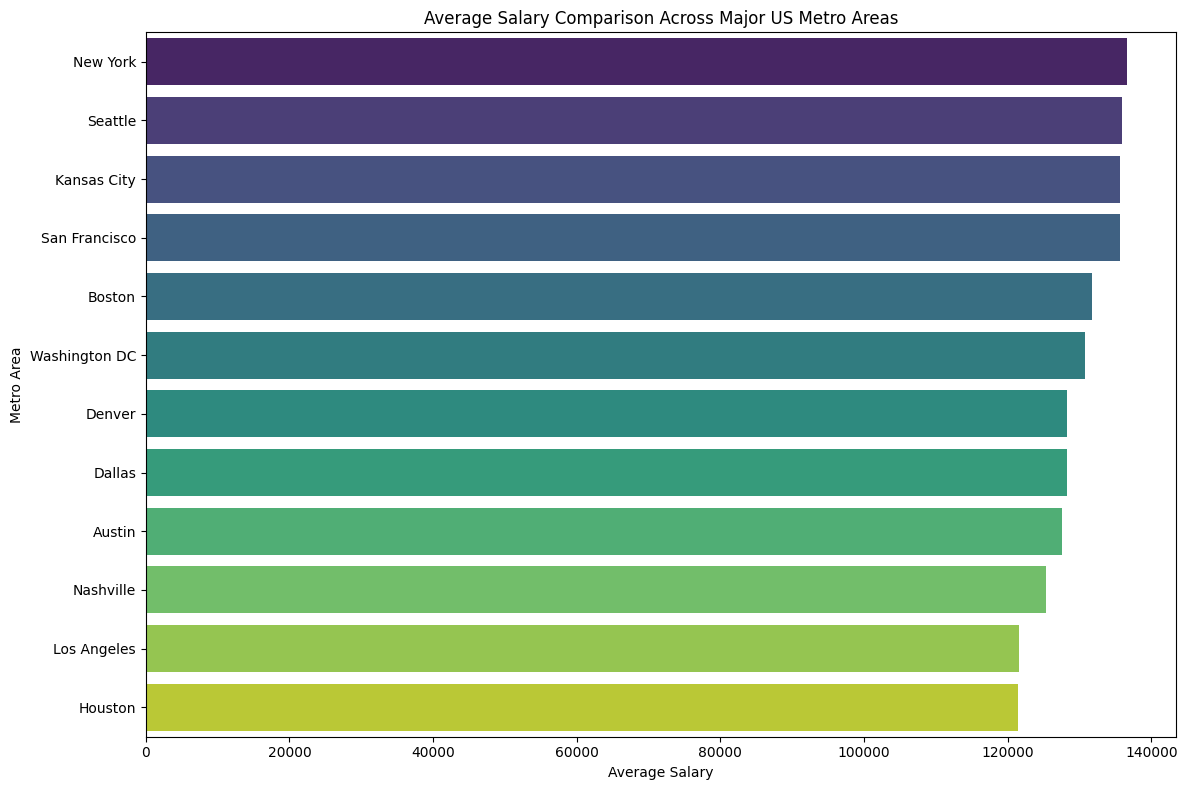

In [17]:

# Query 4 – Salary Comparisons Across Major US Cities

msa_list = [14460,47900,35620,41860,42660,31080,19100,26420,12420,34980,28140,19740]
salary_comparison_cities = spark.sql(f"""
WITH base AS (
  SELECT
    l.MSA,
    l.MSA_NAME,
    j.SALARY
  FROM job_postings j
  JOIN locations l ON j.LOCATION_ID = l.LOCATION_ID
  WHERE j.SALARY IS NOT NULL AND j.SALARY > 0
    AND l.MSA IN ({",".join(map(str, msa_list))})
),
named AS (
  SELECT
    CASE CAST(MSA AS INT)
      WHEN 14460 THEN 'Boston'
      WHEN 47900 THEN 'Washington DC'
      WHEN 35620 THEN 'New York'
      WHEN 41860 THEN 'San Francisco'
      WHEN 42660 THEN 'Seattle'
      WHEN 31080 THEN 'Los Angeles'
      WHEN 19100 THEN 'Dallas'
      WHEN 26420 THEN 'Houston'
      WHEN 12420 THEN 'Austin'
      WHEN 34980 THEN 'Nashville'
      WHEN 28140 THEN 'Kansas City'
      WHEN 19740 THEN 'Denver'
      ELSE COALESCE(MSA_NAME,'Unknown')
    END AS metro,
    SALARY
  FROM base
)
SELECT
  metro,
  ROUND(AVG(SALARY), 2) AS average_salary,
  COUNT(*) AS job_count
FROM named
GROUP BY metro
ORDER BY average_salary DESC
""")

salary_comparison_cities.show()


salary_comparison_cities_pd = salary_comparison_cities.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(
    data=salary_comparison_cities_pd,
    x="average_salary",
    y="metro",
    palette="viridis",
    hue="metro",  # Set hue to the y-axis variable
    legend=False  # Hide the legend
)
plt.title("Average Salary Comparison Across Major US Metro Areas")
plt.xlabel("Average Salary")
plt.ylabel("Metro Area")
plt.tight_layout()
plt.savefig('output/salary_comparison_cities.png')
plt.show()
